In [2]:
# get key
import pandas as pd

keys = pd.read_csv("keys/keys_hezhang.csv", index_col=0)
openai_key = keys.loc["openai", "key_value"]

In [3]:
import openai
openai.api_type = "azure"
openai.api_base = "https://explore-openai.openai.azure.com/"
openai.api_version = "2022-12-01"
openai.api_key = openai_key

model = "text-davinci-003"

In [4]:
import plotly
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from openai.embeddings_utils import get_embedding

embedding_model = "text-search-babbage-doc-001"
pd.set_option("display.max_columns", 100, "display.max_rows", 100, "display.max_colwidth", None) 

## 1. Load Data 

In [7]:
# load the CNN-Daily-Mail data set
data_df = pd.read_csv("data/cnn_dailymail_data.csv")

# random sampling a subset to ease the analysis
subset_df = data_df.sample(200, random_state=0)
subset_df.info()
subset_df.head(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 2365 to 9295
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          200 non-null    object
 1   article     200 non-null    object
 2   highlights  200 non-null    object
dtypes: object(3)
memory usage: 6.2+ KB


,id,article,highlights
2365,31da329bfbf7c248bd47880ad7e780abe8c7fd7c,"An Iranian cleric is teaching his followers that thinking about another woman while having sex with your wife will make your children gay. Ayatollah Hossein Dehnavi, a celebrity preacher in Iran, made the speech to a packed auditorium of men and women in his home country. It is the latest controversial teaching put forward by Dehnavi, who also warned that if women did not wear the hijab - the veil covering the hair and chest - properly, they could inadvertently cause some men to become homosexual. Islamic cleric Dehnavi is a celebrity in his native Iran, giving speeches on relationships and family values . While thinking about another woman while having sex with your wife is not a sin, the Iranian ayatollah preaches, if she becomes pregnant it will mean the child will be gay. Homosexuality is punishable by death in the state . On past occasions He has preached that women must provide sex to their husbands at all times - and said women who are better educated or are financially independent 'harm men's authority'. 'One of the other duties of women in regard to their men is to take care of their men’s instinctive needs [sexual drive]', the cleric said in a report by The Clarion Project, an organisation against extremism. 'Do not break their pride and [you must] be more sensitive toward them' During another speech, the ayatollah explain that it is not a sin for a man to think about another woman while he is having sex with his partner, but if she becomes pregnant as a result the child will be gay. Incorrectly wearing the hijab, Dehnavi also warns, could lead to some men becoming homosexual. Hundreds of women attend the lectures and speeches of the Muslim cleric, whose is also regularly shown on state TV . The statements, thought to have been made in 2012 and 2013, came to light after being shared by Gay Star News this week. Homosexual acts are punishable by death in Iran, with gay and lesbian people forced to hide their sexuality. A man involved in the 'dominant' role in sodomy faces being flogged up to 100 times if he is unmarried and the sex is consensual, while the man playing the 'passive' can still be put to death regardless of his marriage status, according to a report in The Guardian. Lesbians faced being whipped 100 times, but sex between two women can also lead to the death penalty if the act is committed four times. Following his teachings, Dehavni says, will ultimately lead to 'peace on earth'. In another speech he controversially suggested that women should always be sexually available for their husbands . Men become 'saturated' if they have too much sex, Dehavni warns - suggesting becoming intimate once or twice a week is enough. He also says women can make their husbands aroused by showing off their armpits . Dehavni is a celebrated cleric in Iran, whose speeches on family life and marital affairs are shown on state TV and who people queue up for tickets to see him speak live, according to Iran Wire. The 53-year-old grandfather has himself been married for 30 years . In other speeches he warns Iranian couples not to have too much sex: '.. only once or twice a week, not every day. Otherwise the wan will become saturated.' He also suggests paler women wear black underwear and show off the most attractive parts of their bodies - their armpits and chest - to entice their husbands. By perfecting the art of lovemaking, he suggests, couples will have bigger families with strong Muslim values which will ultimately lead to peace on earth.",Ayatollah Hossein Dehnavi made statement during marriage advice speech .\nAlso claims women not wearing hijab properly could make men gay .\nHomosexuals face persecution in Iran under strict Islamic regime .


## 2. Create Embeddings 

In [8]:
# limit article size
max_size = 1408
subset_df["article_short"] = subset_df["article"].str.split(
    n=max_size).str[:max_size].str.join(" ")

subset_df.info()
subset_df.head(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 2365 to 9295
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             200 non-null    object
 1   article        200 non-null    object
 2   highlights     200 non-null    object
 3   article_short  200 non-null    object
dtypes: object(4)
memory usage: 7.8+ KB


,id,article,highlights,article_short
2365,31da329bfbf7c248bd47880ad7e780abe8c7fd7c,"An Iranian cleric is teaching his followers that thinking about another woman while having sex with your wife will make your children gay. Ayatollah Hossein Dehnavi, a celebrity preacher in Iran, made the speech to a packed auditorium of men and women in his home country. It is the latest controversial teaching put forward by Dehnavi, who also warned that if women did not wear the hijab - the veil covering the hair and chest - properly, they could inadvertently cause some men to become homosexual. Islamic cleric Dehnavi is a celebrity in his native Iran, giving speeches on relationships and family values . While thinking about another woman while having sex with your wife is not a sin, the Iranian ayatollah preaches, if she becomes pregnant it will mean the child will be gay. Homosexuality is punishable by death in the state . On past occasions He has preached that women must provide sex to their husbands at all times - and said women who are better educated or are financially independent 'harm men's authority'. 'One of the other duties of women in regard to their men is to take care of their men’s instinctive needs [sexual drive]', the cleric said in a report by The Clarion Project, an organisation against extremism. 'Do not break their pride and [you must] be more sensitive toward them' During another speech, the ayatollah explain that it is not a sin for a man to think about another woman while he is having sex with his partner, but if she becomes pregnant as a result the child will be gay. Incorrectly wearing the hijab, Dehnavi also warns, could lead to some men becoming homosexual. Hundreds of women attend the lectures and speeches of the Muslim cleric, whose is also regularly shown on state TV . The statements, thought to have been made in 2012 and 2013, came to light after being shared by Gay Star News this week. Homosexual acts are punishable by death in Iran, with gay and lesbian people forced to hide their sexuality. A man involved in the 'dominant' role in sodomy faces being flogged up to 100 times if he is unmarried and the sex is consensual, while the man playing the 'passive' can still be put to death regardless of his marriage status, according to a report in The Guardian. Lesbians faced being whipped 100 times, but sex between two women can also lead to the death penalty if the act is committed four times. Following his teachings, Dehavni says, will ultimately lead to 'peace on earth'. In another speech he controversially suggested that women should always be sexually available for their husbands . Men become 'saturated' if they have too much sex, Dehavni warns - suggesting becoming intimate once or twice a week is enough. He also says women can make their husbands aroused by showing off their armpits . Dehavni is a celebrated cleric in Iran, whose speeches on family life and marital affairs are shown on state TV and who people queue up for tickets to see him speak live, according to Iran Wire. The 53-year-old grandfather has himself been married for 30 years . In other speeches he warns Iranian couples not to have too much sex: '.. only once or twice a week, not every day. Otherwise the wan will become saturated.' He also suggests paler women wear black underwear and show off the most attractive parts of their bodies - their armpits and chest - to entice their husbands. By perfecting the art of lovemaking, he suggests, couples will have bigger families with strong Muslim values which will ultimately lead to peace on earth.",Ayatollah Hossein Dehnavi made statement during marriage advice speech .\nAlso claims women not wearing hijab properly could make men gay .\nHomosexuals face persecution in Iran under strict Islamic regime .,"An Iranian cleric is teaching his followers that thinking about another woman while having sex with your wife will make your children gay. Ayatollah Hossein Dehnavi, a celebrity preacher in Iran, made t

In [9]:
%%time
# create embeddings for each article 
subset_df["babbage_search_embedding"] = subset_df["article_short"].apply(
    lambda x: get_embedding(x, engine=embedding_model))

subset_df.info()
subset_df.head(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 2365 to 9295
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        200 non-null    object
 1   article                   200 non-null    object
 2   highlights                200 non-null    object
 3   article_short             200 non-null    object
 4   babbage_search_embedding  200 non-null    object
dtypes: object(5)
memory usage: 9.4+ KB
CPU times: user 600 ms, sys: 23.1 ms, total: 624 ms
Wall time: 38.1 s


,id,article,highlights,article_short,babbage_search_embedding
2365,31da329bfbf7c248bd47880ad7e780abe8c7fd7c,"An Iranian cleric is teaching his followers that thinking about another woman while having sex with your wife will make your children gay. Ayatollah Hossein Dehnavi, a celebrity preacher in Iran, made the speech to a packed auditorium of men and women in his home country. It is the latest controversial teaching put forward by Dehnavi, who also warned that if women did not wear the hijab - the veil covering the hair and chest - properly, they could inadvertently cause some men to become homosexual. Islamic cleric Dehnavi is a celebrity in his native Iran, giving speeches on relationships and family values . While thinking about another woman while having sex with your wife is not a sin, the Iranian ayatollah preaches, if she becomes pregnant it will mean the child will be gay. Homosexuality is punishable by death in the state . On past occasions He has preached that women must provide sex to their husbands at all times - and said women who are better educated or are financially independent 'harm men's authority'. 'One of the other duties of women in regard to their men is to take care of their men’s instinctive needs [sexual drive]', the cleric said in a report by The Clarion Project, an organisation against extremism. 'Do not break their pride and [you must] be more sensitive toward them' During another speech, the ayatollah explain that it is not a sin for a man to think about another woman while he is having sex with his partner, but if she becomes pregnant as a result the child will be gay. Incorrectly wearing the hijab, Dehnavi also warns, could lead to some men becoming homosexual. Hundreds of women attend the lectures and speeches of the Muslim cleric, whose is also regularly shown on state TV . The statements, thought to have been made in 2012 and 2013, came to light after being shared by Gay Star News this week. Homosexual acts are punishable by death in Iran, with gay and lesbian people forced to hide their sexuality. A man involved in the 'dominant' role in sodomy faces being flogged up to 100 times if he is unmarried and the sex is consensual, while the man playing the 'passive' can still be put to death regardless of his marriage status, according to a report in The Guardian. Lesbians faced being whipped 100 times, but sex between two women can also lead to the death penalty if the act is committed four times. Following his teachings, Dehavni says, will ultimately lead to 'peace on earth'. In another speech he controversially suggested that women should always be sexually available for their husbands . Men become 'saturated' if they have too much sex, Dehavni warns - suggesting becoming intimate once or twice a week is enough. He also says women can make their husbands aroused by showing off their armpits . Dehavni is a celebrated cleric in Iran, whose speeches on family life and marital affairs are shown on state TV and who people queue up for tickets to see him speak live, according to Iran Wire. The 53-year-old grandfather has himself been married for 30 years . In other speeches he warns Iranian couples not to have too much sex: '.. only once or twice a week, not every day. Otherwise the wan will become saturated.' He also suggests paler women wear black underwear and show off the most attractive parts of their bodies - their armpits and chest - to entice their husbands. By perfecting the art of lovemaking, he suggests, couples will have bigger families with strong Muslim values which will ultimately lead to peace on earth.",Ayatollah Hossein Dehnavi made statement during marriage advice speech .\nAlso claims women not wearing hijab properly could make men gay .\nHomosexuals face persecution in Iran under strict Islamic regime .,"An Iranian cleric is teaching his followers that thinking about another woman while having sex with your wife will make your children gay. Ayatollah Hossein Dehnavi, a celebrity

## 3. Clustering Analysis

In [10]:
# clustering the articles using KMeans
n_clusters = 6
embedding_matrix =np.vstack(subset_df.babbage_search_embedding.values) 

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", n_init=10, random_state=0)
kmeans.fit(embedding_matrix)
labels = kmeans.labels_
subset_df["cluster_label"] = labels

subset_df.info()
subset_df.head(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 2365 to 9295
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        200 non-null    object
 1   article                   200 non-null    object
 2   highlights                200 non-null    object
 3   article_short             200 non-null    object
 4   babbage_search_embedding  200 non-null    object
 5   cluster_label             200 non-null    int32 
dtypes: int32(1), object(5)
memory usage: 10.2+ KB


,id,article,highlights,article_short,babbage_search_embedding,cluster_label
2365,31da329bfbf7c248bd47880ad7e780abe8c7fd7c,"An Iranian cleric is teaching his followers that thinking about another woman while having sex with your wife will make your children gay. Ayatollah Hossein Dehnavi, a celebrity preacher in Iran, made the speech to a packed auditorium of men and women in his home country. It is the latest controversial teaching put forward by Dehnavi, who also warned that if women did not wear the hijab - the veil covering the hair and chest - properly, they could inadvertently cause some men to become homosexual. Islamic cleric Dehnavi is a celebrity in his native Iran, giving speeches on relationships and family values . While thinking about another woman while having sex with your wife is not a sin, the Iranian ayatollah preaches, if she becomes pregnant it will mean the child will be gay. Homosexuality is punishable by death in the state . On past occasions He has preached that women must provide sex to their husbands at all times - and said women who are better educated or are financially independent 'harm men's authority'. 'One of the other duties of women in regard to their men is to take care of their men’s instinctive needs [sexual drive]', the cleric said in a report by The Clarion Project, an organisation against extremism. 'Do not break their pride and [you must] be more sensitive toward them' During another speech, the ayatollah explain that it is not a sin for a man to think about another woman while he is having sex with his partner, but if she becomes pregnant as a result the child will be gay. Incorrectly wearing the hijab, Dehnavi also warns, could lead to some men becoming homosexual. Hundreds of women attend the lectures and speeches of the Muslim cleric, whose is also regularly shown on state TV . The statements, thought to have been made in 2012 and 2013, came to light after being shared by Gay Star News this week. Homosexual acts are punishable by death in Iran, with gay and lesbian people forced to hide their sexuality. A man involved in the 'dominant' role in sodomy faces being flogged up to 100 times if he is unmarried and the sex is consensual, while the man playing the 'passive' can still be put to death regardless of his marriage status, according to a report in The Guardian. Lesbians faced being whipped 100 times, but sex between two women can also lead to the death penalty if the act is committed four times. Following his teachings, Dehavni says, will ultimately lead to 'peace on earth'. In another speech he controversially suggested that women should always be sexually available for their husbands . Men become 'saturated' if they have too much sex, Dehavni warns - suggesting becoming intimate once or twice a week is enough. He also says women can make their husbands aroused by showing off their armpits . Dehavni is a celebrated cleric in Iran, whose speeches on family life and marital affairs are shown on state TV and who people queue up for tickets to see him speak live, according to Iran Wire. The 53-year-old grandfather has himself been married for 30 years . In other speeches he warns Iranian couples not to have too much sex: '.. only once or twice a week, not every day. Otherwise the wan will become saturated.' He also suggests paler women wear black underwear and show off the most attractive parts of their bodies - their armpits and chest - to entice their husbands. By perfecting the art of lovemaking, he suggests, couples will have bigger families with strong Muslim values which will ultimately lead to peace on earth.",Ayatollah Hossein Dehnavi made statement during marriage advice speech .\nAlso claims women not wearing hijab properly could make men gay .\nHomosexuals face persecution in Iran under strict Islamic regime .,"An Iranian cleric is teaching his followers that thinking about another woman while having sex with your wife will make your children gay. Ayatollah Hossein Dehnav

Text(0.5, 1.0, 'Clusters Identified Using t-SNE')

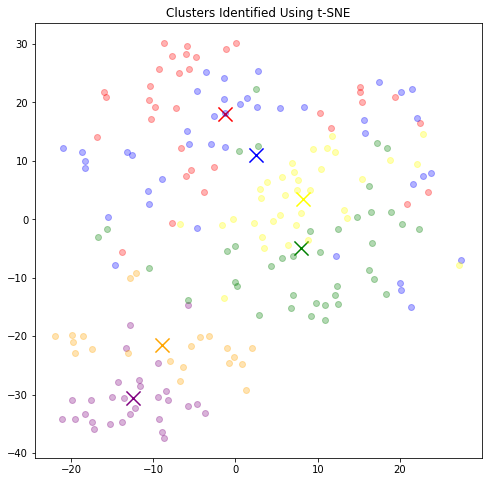

In [11]:
# clustering using t-SNE
tsne = TSNE(n_components=2, perplexity=15, random_state=0, init="random")
vis_dims2 = tsne.fit_transform(embedding_matrix)
x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

# creating scattering plots
plt.figure(figsize=(8, 8))
for category, color in enumerate(["purple", "green", "red", "blue","yellow","orange"]):
    xs = np.array(x)[subset_df.cluster_label==category]
    ys = np.array(y)[subset_df.cluster_label==category]
    plt.scatter(xs, ys, color=color, alpha=0.3)
    avg_x = xs.mean()
    avg_y = ys.mean()
    plt.scatter(avg_x, avg_y, marker="x", color=color, s=200)
    
plt.title("Clusters Identified Using t-SNE")

## 4. Summarize Each Article With OpenAI

In [12]:
# define a helper function for submitting summarization api calls
def summarize_text(text):
    """This function submits summarization api calls."""
    prompt = f"""Summarize below text in 2 short sentences:
                 
                 ###{text}
              """
    response = openai.Completion.create(
        engine=model,
        prompt=prompt,
        temperature=0.7,
        max_tokens=80,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0)

    return(response["choices"][0]["text"].replace("\n", ""))

In [13]:
%%time
# create summary for each article
subset_df["summary"] = subset_df["article_short"].apply(lambda x: summarize_text(x))

subset_df.info()
subset_df.head(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 2365 to 9295
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        200 non-null    object
 1   article                   200 non-null    object
 2   highlights                200 non-null    object
 3   article_short             200 non-null    object
 4   babbage_search_embedding  200 non-null    object
 5   cluster_label             200 non-null    int32 
 6   summary                   200 non-null    object
dtypes: int32(1), object(6)
memory usage: 11.7+ KB
CPU times: user 525 ms, sys: 40.6 ms, total: 566 ms
Wall time: 3min 49s


,id,article,highlights,article_short,babbage_search_embedding,cluster_label,summary
2365,31da329bfbf7c248bd47880ad7e780abe8c7fd7c,"An Iranian cleric is teaching his followers that thinking about another woman while having sex with your wife will make your children gay. Ayatollah Hossein Dehnavi, a celebrity preacher in Iran, made the speech to a packed auditorium of men and women in his home country. It is the latest controversial teaching put forward by Dehnavi, who also warned that if women did not wear the hijab - the veil covering the hair and chest - properly, they could inadvertently cause some men to become homosexual. Islamic cleric Dehnavi is a celebrity in his native Iran, giving speeches on relationships and family values . While thinking about another woman while having sex with your wife is not a sin, the Iranian ayatollah preaches, if she becomes pregnant it will mean the child will be gay. Homosexuality is punishable by death in the state . On past occasions He has preached that women must provide sex to their husbands at all times - and said women who are better educated or are financially independent 'harm men's authority'. 'One of the other duties of women in regard to their men is to take care of their men’s instinctive needs [sexual drive]', the cleric said in a report by The Clarion Project, an organisation against extremism. 'Do not break their pride and [you must] be more sensitive toward them' During another speech, the ayatollah explain that it is not a sin for a man to think about another woman while he is having sex with his partner, but if she becomes pregnant as a result the child will be gay. Incorrectly wearing the hijab, Dehnavi also warns, could lead to some men becoming homosexual. Hundreds of women attend the lectures and speeches of the Muslim cleric, whose is also regularly shown on state TV . The statements, thought to have been made in 2012 and 2013, came to light after being shared by Gay Star News this week. Homosexual acts are punishable by death in Iran, with gay and lesbian people forced to hide their sexuality. A man involved in the 'dominant' role in sodomy faces being flogged up to 100 times if he is unmarried and the sex is consensual, while the man playing the 'passive' can still be put to death regardless of his marriage status, according to a report in The Guardian. Lesbians faced being whipped 100 times, but sex between two women can also lead to the death penalty if the act is committed four times. Following his teachings, Dehavni says, will ultimately lead to 'peace on earth'. In another speech he controversially suggested that women should always be sexually available for their husbands . Men become 'saturated' if they have too much sex, Dehavni warns - suggesting becoming intimate once or twice a week is enough. He also says women can make their husbands aroused by showing off their armpits . Dehavni is a celebrated cleric in Iran, whose speeches on family life and marital affairs are shown on state TV and who people queue up for tickets to see him speak live, according to Iran Wire. The 53-year-old grandfather has himself been married for 30 years . In other speeches he warns Iranian couples not to have too much sex: '.. only once or twice a week, not every day. Otherwise the wan will become saturated.' He also suggests paler women wear black underwear and show off the most attractive parts of their bodies - their armpits and chest - to entice their husbands. By perfecting the art of lovemaking, he suggests, couples will have bigger families with strong Muslim values which will ultimately lead to peace on earth.",Ayatollah Hossein Dehnavi made statement during marriage advice speech .\nAlso claims women not wearing hijab properly could make men gay .\nHomosexuals face persecution in Iran under strict Islamic regime .,"An Iranian cleric is teaching his followers that thinking about another woman while having sex with your wife will make your children gay. Ayatollah Hossei

## 5. Show Cluster Topics With Sample Summaries

In [14]:
# generate cluster topics with samples 
article_per_cluster = 4
for i in range(n_clusters):
    print(f"Cluster {i+1} Topic:", end=" ")
    # sample a subset articles
    articles = "\n".join(subset_df[subset_df.cluster_label==i]
                         .summary.str.replace("\n\n", ":  ")
                         .sample(article_per_cluster, random_state=0).values)
    # create prompt
    prompt = f"""The following articles belong to which news topic?
                 
                 ###articles:{articles}
                 
                 News Topic:
              """
    # summarize via openai
    response=openai.Completion.create(
        engine=model,
        prompt=prompt,
        temperature=0,
        max_tokens=100,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", ""))
    print("\n")
    # show sample summaries
    sample_cluster_rows = subset_df[subset_df.cluster_label==i].sample(
        article_per_cluster, random_state=0)
    for j in range(article_per_cluster):
        print(str(j+1), end=": ")
        print(sample_cluster_rows.summary.values[j])
        print("\n")
        #print(sample_cluster_rows.article.str[:70].values[j])

    print("-" * 80 + "\n")

Cluster 1 Topic:  Football


1: Real Madrid were in high spirits ahead of their Champions League quarter-final second leg clash against Atletico Madrid, and were play-fighting much to the amusement of those watching. Karim Benzema is out due to injury, and Gareth Bale, Luka Modric, and Marcelo are also unavailable for the match.


2: Danny Wilson has activated a clause in his contract to leave Hearts this summer, despite having a further year on his deal. He will leave the club at the end of the season with the blessing of manager Robbie Neilson and the appreciation of the fans.


3: Bristol City have had an almost perfect season, becoming the first team in the Football League to mathematically secure promotion and winning the Johnstone's Paint Trophy at Wembley. They aim to reach the Premier League with the support of their billionaire owner Steve Lansdown.


4: Adrian Peterson has been officially reinstated by the NFL and will be able to participate in all scheduled activities with t